In [1]:
from WGS import WGS
from Planner.Myopic3D import Myopic3D
from usr_func.checkfolder import checkfolder
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
from pykdtree.kdtree import KDTree
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
from matplotlib.gridspec import GridSpec


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Set up GMRF kernel planner
myopic3d_gmrf = Myopic3D(kernel="GMRF")
waypoints = myopic3d_gmrf.wp.get_waypoints()
waypoints_tree = KDTree(waypoints)
figpath = os.getcwd() + "/../fig/Experiment/"
checkfolder(figpath)
os.listdir(figpath)
depths = np.unique(waypoints[:, 2])

# Set up GRF kernel planner
myopic3d_grf = Myopic3D(kernel="GRF")

Treshold is set to 25.40
Treshold is set to 25.40
KDTree construction time:  0.6724112033843994
Data is interpolated successfully! Time consumed:  0.008768081665039062
Loading interpolators finished, time cost: 1.13 s


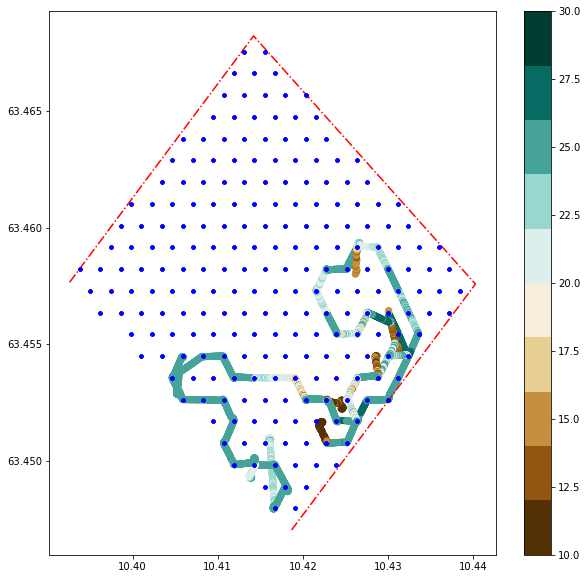

In [3]:
filepath = os.getcwd() + "/csv/AUVData.csv"
df = pd.read_csv(filepath)

x, y = WGS.latlon2xy(df['lat'], df['lon'])
visited_locs = np.stack((x, y, df['depth']), axis=1)

polygon_border = pd.read_csv("box.csv").to_numpy()

waypoints = myopic3d_gmrf.wp.get_waypoints()
lat_wp, lon_wp = WGS.xy2latlon(waypoints[:, 0], waypoints[:, 1])
waypoints_wgs = np.stack((lat_wp, lon_wp), axis=1)

plt.figure(figsize=(10, 10))
plt.plot(polygon_border[:, 1], polygon_border[:, 0], 'r-.')
plt.plot(waypoints_wgs[:, 1], waypoints_wgs[:, 0], 'b.')
plt.scatter(df['lon'], df['lat'], c=df['salinity'], cmap=get_cmap("BrBG", 10), vmin=10, vmax=30)
plt.colorbar()

In [6]:
dist = []
counter = 0
prev_loc = waypoints[0, :]
ind_prev = 0
for i in range(visited_locs.shape[0]):
    dist_temp, ind = waypoints_tree.query(visited_locs[i, :].reshape(1, -1))
    dist.append(dist_temp)
    if (dist_temp < 5) and (cal_distance_between_two_locs(prev_loc, visited_locs[i, :]) > 10):
        ctd_data = np.hstack((visited_locs[ind_prev:i, :], 
                              np.array(df['salinity']).reshape(-1, 1)[ind_prev:i, :]))

        # Section to use GRF to plan the next waypoint
        if counter == 0: 
            myopic3d_grf.set_current_index(ind)
            myopic3d_grf.set_next_index(ind)
            id_temp = myopic3d_grf.get_pioneer_waypoint_index()
            myopic3d_grf.set_next_index(id_temp)

            myopic3d_grf.update_planner()
            myopic3d_grf.get_pioneer_waypoint_index()
            
            myopic3d_grf.kernel.assimilate_data(ctd_data)

        else:
            myopic3d_grf.kernel.assimilate_data(ctd_data)
            myopic3d_grf.update_planner()
            myopic3d_grf.get_pioneer_waypoint_index()
        ind_grf = myopic3d_grf.get_next_index()

        plot_neighbour_on_waypoint_graph_2d(visited_locs[:i, :], waypoints[ind, :], waypoints[ind_grf, :], counter)

        counter += 1
        ind_prev = i
        prev_loc = visited_locs[i, :]

print(counter)

IndexError: index 1 is out of bounds for axis 0 with size 1

(1350, 3)

In [5]:
def cal_distance_between_two_locs(loc1, loc2):
    dx = loc1[0] - loc2[0]
    dy = loc1[1] - loc2[1]
    dz = loc1[2] - loc2[2]
    return np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

def plot_neighbour_on_waypoint_graph_2d(visited_locs, activated_waypoints, grf_waypoints, counter): 
    print("counter: ", counter)

    plt.figure(figsize=(54, 8))
    gs = GridSpec(1, 6, figure=plt.gcf())

    def plot_subplot(i): 
        ax = plt.subplot(gs[i])
        ind_layer = np.where(waypoints[:, 2] == depths[i])[0]
        ax.plot(waypoints[ind_layer, 1], waypoints[ind_layer, 0], 'k.', alpha=.3)
        ind_depth = np.where(np.abs(visited_locs[:, 2] - depths[i]) < .25)[0]
        ax.plot(visited_locs[:, 1], visited_locs[:, 0], 'b-', alpha=.5)
        ax.plot(visited_locs[ind_depth, 1], visited_locs[ind_depth, 0], 'b.' )
        if activated_waypoints[0, 2] == depths[i]:
            ax.plot(activated_waypoints[:, 1], activated_waypoints[:, 0], 'r.', markersize=10)
        if grf_waypoints[0, 2] == depths[i]:
            ax.plot(grf_waypoints[:, 1], grf_waypoints[:, 0], 'g.', markersize=10)
        ax.axis('equal')
        ax.set_title("Depth: {:.2f}".format(depths[i]))
    
    for i in range(6):
        # print(i) 
        plot_subplot(i)
    
    plt.savefig(figpath + "P_{:03d}.png".format(counter))
    plt.close("all")
    

def plot_neighbour_on_waypoint_graph(visited_locs, activated_waypoints, counter):
    fig = make_subplots(rows=1, cols=1, specs=[[{"type": "scene"}]])

    fig.add_trace(
        go.Scatter3d(
            x=waypoints[:, 1],
            y=waypoints[:, 0],
            z=-waypoints[:, 2],
            mode="markers",
            marker=dict(
                size=10,
                color="black",
                opacity=0.5,
            ),
            name="Waypoints",
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter3d(
            x=visited_locs[:, 1],
            y=visited_locs[:, 0],
            z=-visited_locs[:, 2],
            mode="markers + lines",
            marker=dict(
                size=1,
                color="blue",
                opacity=0.5,
            ),
            line=dict(
                color="yellow",
                width=2,
            ),
            name="Visited Locations",
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter3d(
            x=activated_waypoints[:, 1],
            y=activated_waypoints[:, 0],
            z=-activated_waypoints[:, 2],
            mode="markers",
            marker=dict(
                size=20,
                color="red",
            ),
            name="Activated Waypoints",
        ),
        row=1,
        col=1,
    )

    # fig.update_layout(
    #     title="Waypoints",
    #     autosize=False,
    #     width=1000,
    #     height=1000,
    #     margin=dict(l=65, r=50, b=65, t=90),
    #     scene=dict(
    #         xaxis=dict(title="East"),
    #         yaxis=dict(title="North"),
    #         zaxis=dict(title="Depth"),
    #     ),
    #     legend=dict(
    #         yanchor="top",
    #         y=0.99,
    #         xanchor="left",
    #         x=0.01,
    #     ),
    # )

    plotly.offline.plot(fig, filename=figpath + "P_{:03d}.html".format(counter), auto_open=False)
